### Importing ANI Tools and Viewing Data

In [1]:
import pyanitools as pya
import pandas as pd
import numpy as np
import torch
from sys import exit

# Set the HDF5 file containing the data
hdf5file = 'ani_gdb_s01.h5'

# Construct the data loader class
adl = pya.anidataloader(hdf5file)

p = []
x = []
e = []
s = []
sm = []
i = 0

for data in adl:
    if (i >= 10):
        break
    # Extract the data
    p.append(data['path'])
    x.append(data['coordinates'])
    e.append(data['energies'])
    s.append(data['species'])
    sm.append(data['smiles'])
    i+=1
    



# Closes the H5 data file
adl.cleanup()


In [26]:
from pyanitools import anidataloader
# data = anidataloader("../../ANI1_dataset/ANI-1_release/ani_gdb_s07.h5")
data = anidataloader("ani_gdb_s01.h5")
data_iter = data.__iter__()

In [6]:
mols = next(data_iter)
# Extract the data
P = mols['path']
X = mols['coordinates']
E = mols['energies']
S = mols['species']
sm = mols['smiles']

# Print the data
print("Path:   ", P)
print("  Smiles:      ","".join(sm))
print("  Symbols:     ", S)
print("  Coordinates: ", X.shape)
print("  Energies:    ", E.shape, "\n")
print("  Energies: ", E)
print(E.shape)

Path:    /gdb11_s01/gdb11_s01-0
  Smiles:       [H]C([H])([H])[H]
  Symbols:      ['C', 'H', 'H', 'H', 'H']
  Coordinates:  (5400, 5, 3)
  Energies:     (5400,) 

  Energies:  [-40.48058817 -40.48311923 -40.48473545 ... -40.4961279  -40.45599721
 -40.46479283]
(5400,)


In [ ]:
data_iter = data.__iter__()
count = 0
count_conf = 0
for mol in data_iter:
    count += 1
    count_conf += len(mol['energies'])
print(count)
print(count_conf)

3
10800


### Installing Torchani and AEVComputer

In [3]:
!pip install torchani

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 8.4 MB/s eta 0:00:00


In [4]:
import torchani
from torchani import AEVComputer
Rcr = 5.2
EtaR = torch.tensor([16], dtype=torch.float)
ShfR = torch.tensor([0.900000,1.168750,1.437500,1.706250,1.975000,2.243750,2.51250,2.781250,3.050000,3.318750,3.587500,3.856250,4.125000,4.39375,4.662500,4.931250])
Rca = 3.5
EtaA = torch.tensor([8], dtype=torch.float)
ShfA = torch.tensor([0.900000,1.550000,2.200000,2.850000], dtype=torch.float)
ShfZ = torch.tensor([0.19634954,0.58904862,0.9817477,1.3744468,1.7671459,2.1598449,2.552544,2.945243]) 
Zeta = torch.tensor([32], dtype=torch.float)
species_order = ['H', 'C', 'N', 'O']
num_species = len(species_order)

aev_computer = torchani.AEVComputer(Rcr, Rca, EtaR, ShfR, EtaA, ShfA, ShfZ, Zeta, num_species)


/usr/local/lib/python3.9/dist-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")
/usr/local/lib/python3.9/dist-packages/torchani/__init__.py:55: UserWarning: Dependency not satisfied, torchani.ase will not be available
  warnings.warn("Dependency not satisfied, torchani.ase will not be available")


In [7]:
import numpy as np
aev_converter = torchani.AEVComputer(Rcr, Rca, EtaR, ShfR, EtaA, Zeta, ShfA, ShfZ, num_species)
mapping = {"H": 0, "C" : 1, "N": 2, "O": 3}
species = np.array([mapping[atom] for atom in S])
species = np.tile(species, (X.shape[0], 1))
species = torch.tensor(species)
X = torch.tensor(X)

### Running the AEV Computer on first Molecule in All Configurations

In [8]:
aev_output = aev_computer((species, X)) #SPecies: (Number, Atoms) A in [0, 1, 2, 3] Coords: (N, A, 3) Output : (N, A, 384)
aev_output[1].shape

torch.Size([5400, 5, 384])

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### Defining MLP Model with Torch

In [12]:
import torch
from torch import nn

class ANI(nn.Module):
    def __init__(self):
        super().__init__()
        self.sub_nets = nn.ModuleDict({
            "C" : ANI_sub(),
            "H" : ANI_sub(),
            "N" : ANI_sub(),
            "O" : ANI_sub()})
        #print(self.sub_nets)

    def forward(self, aevs, atom_types):
        #atomic_energies = [self.sub_nets[atom_types[i]](aevs[i]) for i in range(aevs.shape[1])]
        atomic_energies = [self.sub_nets[atom_types[i]](aevs[:, i, :]) for i in range(aevs.shape[1])]
        
        atomic_energies = torch.cat(atomic_energies, dim=1)
        total_energies = torch.sum(atomic_energies, dim=1)
        

        return total_energies

class ANI_sub(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(384, 128),
            nn.GELU(),
            nn.Linear(128, 128),
            nn.GELU(),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Linear(64, 1)
        )

    def forward(self, aev):
        atomic_energy = self.layers(aev)
        return atomic_energy


In [13]:
from torchsummary import summary
model = ANI()
species = S
print(species)

out_tensor = model(aev_output[1], S)
print(out_tensor.size())
print(out_tensor)

['C', 'H', 'H', 'H', 'H']
torch.Size([5400])
tensor([-0.0490, -0.0489, -0.0483,  ..., -0.0485, -0.0497, -0.0484],
       grad_fn=<SumBackward1>)


### Defining Torch Trainer Class

In [15]:
from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap

In [68]:
@timing      
def train(model, inputs, species, outputs, epochs, learning_rate):    
    ### convert data to tensor of correct shape and type here ###
    inputs = torch.tensor(inputs, dtype=torch.float32)
    outputs = torch.tensor(outputs, dtype=torch.float32)
    
    
    model = model
    
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    losses = []
    weights = model.state_dict()

    for epoch in range(epochs):
      model.train()
      epoch_loss = 0

      batch_predictions = model.forward(inputs, species)
      loss_func = nn.MSELoss()
      loss = loss_func(batch_predictions, outputs)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      ### Compute epoch_loss
      epoch_loss = evaluate(model, inputs, species, outputs)  
      losses.append(epoch_loss)
    return {"losses": losses}

def evaluate(model, inputs, species, outputs):
        """ evaluate model on provided input and output
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures)
        outputs: np.array shape (ndata,)
        print_acc: bool
        
        @return
        losses: float
        acc: float
        """
        inputs = torch.tensor(inputs, dtype=torch.float32)
        outputs = torch.tensor(outputs, dtype=torch.float32)

        loss_func = nn.MSELoss()
        pred = model.forward(inputs, species)
        losses = loss_func(pred, outputs)
        return losses


### Testing train() function on First Molecule in All Configurations

In [18]:
model = ANI()
out_dict = train(model, aev_output[1], S, E, epochs = 10, learning_rate = 0.01)

<ipython-input-16-6dfaa19614dc>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)


func:'train'  took: 8.3858 sec


In [19]:
print(out_dict)
model.forward(aev_output[1], S)


{'losses': [tensor(1579.9133, grad_fn=<MseLossBackward0>), tensor(1310.0375, grad_fn=<MseLossBackward0>), tensor(757.7924, grad_fn=<MseLossBackward0>), tensor(70.8014, grad_fn=<MseLossBackward0>), tensor(939.4914, grad_fn=<MseLossBackward0>), tensor(159.8139, grad_fn=<MseLossBackward0>), tensor(34.1986, grad_fn=<MseLossBackward0>), tensor(237.3652, grad_fn=<MseLossBackward0>), tensor(351.6028, grad_fn=<MseLossBackward0>), tensor(336.2389, grad_fn=<MseLossBackward0>)]}


tensor([-21.6880, -21.5015, -22.8991,  ..., -21.9989, -21.4074, -22.2985],
       grad_fn=<SumBackward1>)

### Iterating over all Molecules in Input Set

In [129]:
# from torch.utils.data import DataLoader, TensorDataset

# model = ANI()
# data_iter = data.__iter__()
# out = []

# for i in range(count):
#   mols = next(data_iter)
#   #  Extract the data
#   P = mols['path']
#   X = mols['coordinates']
#   E = mols['energies']
#   S = mols['species']
#   sm = mols['smiles']

#   print(f"Training ANI Model on Molecule {i}")
#   print(P)
#   print(S)
#   species = np.array([mapping[atom] for atom in S])
#   species = np.tile(species, (X.shape[0], 1))
#   species = torch.tensor(species)
#   X = torch.tensor(X)

#   aev_output = aev_computer((species, X)) #SPecies: (Number, Atoms) A in [0, 1, 2, 3] Coords: (N, A, 3) Output : (N, A, 384)


#   out.append(train(model, aev_output[1], S, E, epochs=10, learning_rate=1e-3))


In [21]:
from sklearn.model_selection import train_test_split

### Final Training and Testing Loop

In [104]:
def data_gen(X, y, S):
  species = np.array([mapping[atom] for atom in S])
  species = np.tile(species, (X.shape[0], 1))
  species = torch.tensor(species)
  X = torch.tensor(X)
  aev_output = aev_computer((species, X)) #SPecies: (Number, Atoms) A in [0, 1, 2, 3] Coords: (N, A, 3) Output : (N, A, 384)
  return aev_output[1], y

def evaluate(model, inputs, species, outputs):
 
        inputs = torch.tensor(inputs, dtype=torch.float32)
        outputs = torch.tensor(outputs, dtype=torch.float32)

        loss_func = nn.MSELoss()
        pred = model.forward(inputs, species)
        losses = loss_func(pred, outputs)
        return losses

def train_and_test(data, model, epochs, learning_rate):

  val_losses = []

  for i in range(epochs):
    print("Epoch: ", i)
    for mol in data:
          #for mol in d:
          species = mol['species']
          #coords = np.array(mol['coordinates'])
          #energies = np.array(mol['energies'])
          # Do train test split here on coords
          X_train, X_test, y_train, y_test = train_test_split(mol['coordinates'], mol['energies'], test_size = 0.75)
          train_gen = data_gen(X_train, y_train, species) #compute AEVs
          test_gen = data_gen(X_test, y_test, species)
          #for train_X, train_y in train_gen:
              # train on one batch
          train_X = train_gen[0]
          train_y = train_gen[1]
          inputs = torch.tensor(train_X, dtype=torch.float32)
          outputs = torch.tensor(train_y, dtype=torch.float32)
          model = model
          optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

          
          weights = model.state_dict()
          model.train()

          batch_predictions = model.forward(inputs, species)
          loss_func = nn.MSELoss()
          loss = loss_func(batch_predictions, outputs)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

              
          #validation here
          test_X = test_gen[0]
          test_y = test_gen[1]
          val_loss = evaluate(model, test_X, species, test_y)
          #val_loss = 0
          val_losses.append(val_loss.detach().numpy())
  #test here after training finished
  return val_losses          


In [127]:
model = ANI()
# Set the HDF5 file containing the data
hdf5file = 'ani_gdb_s01.h5'

# Construct the data loader class
adl = pya.anidataloader(hdf5file)

losses_vector = train_and_test(adl, model, 30, 0.0075)

Epoch:  0


<ipython-input-104-1f2ee82d4a9a>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(train_X, dtype=torch.float32)
<ipython-input-104-1f2ee82d4a9a>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32)


Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29


90


Text(0, 0.5, 'MSE Loss')

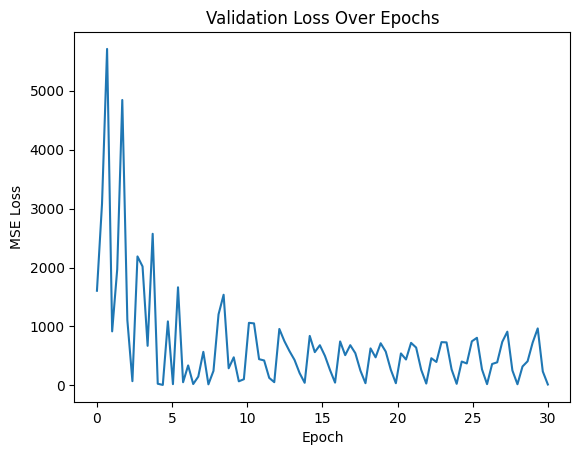

In [128]:
import matplotlib.pyplot as plt
print(len(losses_vector))

plt.plot(np.linspace(0, 30, 90), losses_vector)
plt.title("Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")